<a href="https://colab.research.google.com/github/c-labropoulos/NN-for-lithological-segmentation/blob/main/toRaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [29]:
#!gdalinfo --version
!pip install geopandas
!pip install rasterio
from osgeo import gdal
from osgeo import ogr
import rasterio
import geopandas as gpd

vector = gpd.read_file("/content/drive/MyDrive/LithDatasSHP/Amfilochia.shp")
rst_path='/content/drive/MyDrive/LithDatasTIF/Amfilochia.tif'

# Get list of geometries for all features in vector file
geom = [shapes for shapes in vector.geometry]

# Open example raster
raster = rasterio.open(rst_path)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import numpy as np
# create a numeric unique value for each row

vector['labels_Lit'] = range(0,len(vector))


# create tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = ((geom,value) for geom, value in zip(vector.geometry, vector['labels_Lit']))

# Rasterize vector using the shape and transform of the raster
rasterized = features.rasterize(geom_value,
                                out_shape = raster.shape,
                                transform = raster.transform,
                                all_touched = True,
                                fill = -5,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = np.int16)


#import geopandas as gpd
#df = gpd.read_file('../../Datasets/italy-points-shape/points.shp')
#df.head()

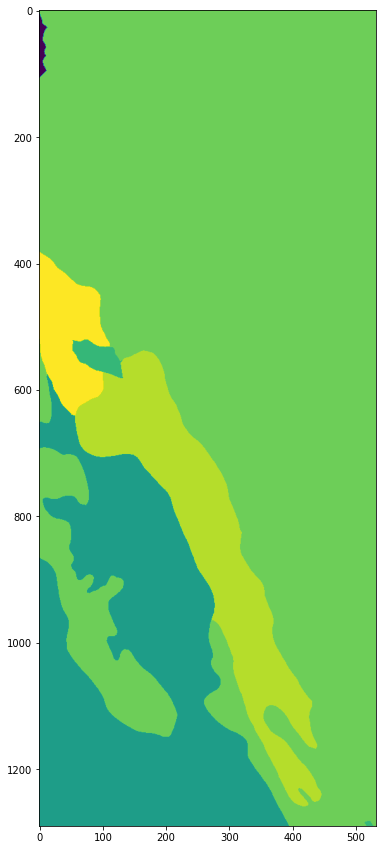

In [31]:
# Plot raster
fig, ax = plt.subplots(1, figsize = (15, 15))
#handles, labels = ax.get_legend_handles_labels(vector['labels_Lit'])
#ax.legend(labels,loc='upper right')
show(rasterized, ax = ax)
plt.gca()
with rasterio.open(
        "/content/drive/MyDrive/raster_to_be_used/Amfilochia_rasterized_vector.tif", "w",
        driver = "GTiff",
        transform = raster.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = raster.width,
        height = raster.height) as dst:
    dst.write(rasterized, indexes = 1)